In [126]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.statespace.tools import diff
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace import sarimax
from sklearn.metrics import mean_squared_error

In [2]:
temps = pd.read_csv('wayland_temperature.csv')
temps['month'] = pd.DatetimeIndex(pd.to_datetime(temps.date)).month
temps['year'] = pd.DatetimeIndex(pd.to_datetime(temps.date)).year
monthly = temps.groupby(['year', 'month'], as_index = False)['max_tmp'].mean()

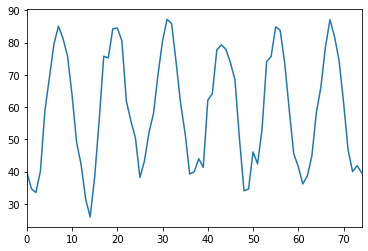

In [7]:
#Leta start with visualiing our time series to decide our first steps
#Plotting average maximum temperature

tmps = monthly.max_tmp.plot()

# We see that this time series has constant mean, constant variance
# However, it does have seasonality, so its not yet stationary

p-value: 0.0


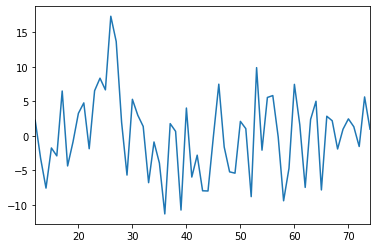

In [8]:
# Now we know we have to use differencing to get our timeseries stationary
# This means ARIMA(p,d,q) (P,D,Q)s . We need at least one D/d to be nonzero
# s=12 because our series is monthly

# Next lets take a look how to make this time series stationary. I assume just D=1 should do it. Lets see:
# Lets apply 1st degree seasonal differencing and plot the result to tune our model
seasonal_diff = diff(monthly.max_tmp, k_diff=0, k_seasonal_diff=1, seasonal_periods=12)
seasonal_diff.plot()

# Lets check to see of Dickey Fuller thinks its stationary:
print('p-value: {}'.format(round(adfuller(seasonal_diff)[1], 3)))
# Dickey fuller says yes!

p-value: 0.0


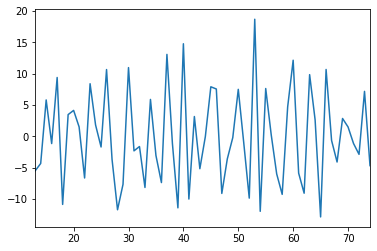

In [9]:
#This looks better, but there is still a bit of nonrandomness/trend going on
# Lets also apply single one after the other differencing to get it stationary
double_diff = diff(monthly.max_tmp, k_diff=1, k_seasonal_diff=1, seasonal_periods=12)
double_diff.plot()

print('p-value: {}'.format(round(adfuller(double_diff)[1], 3)))

# Now this looks great! Lets move forward with d and D both = 1

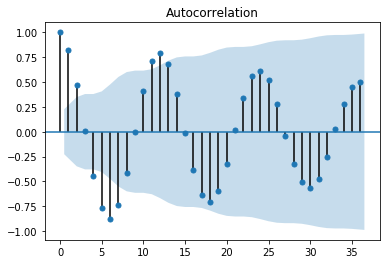

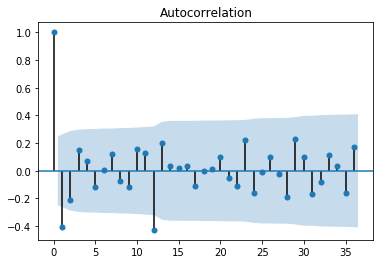

In [12]:
# Now we need to find appropriate lagged moving average parameter
# Lets make some ACF plots
# Lets start with ACF to determine AR models coefficients

#First without any differencing, we see clear yearly seasonality in the ACF plot
acf_p_nodiff = plot_acf(monthly.max_tmp, lags = 36)

#After our differencing was applied, this seasonlity was washed out
acf_p_nodiff = plot_acf(double_diff, lags = 36)
# Looks like we should still include some MA terms 
# Locally, the L looks to have influence, so lets include q=1
# Seasonally, L12 looks to have influence, so lets use Q=1

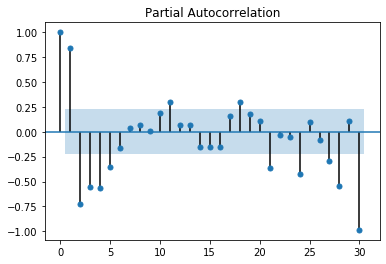

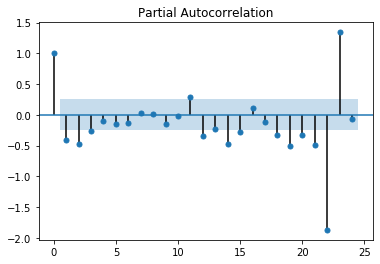

In [22]:
# Now we need to find appropriate lagged moving autoregression parameter
# Lets make some PACF plots
# Lets start with PACF to determine AR models coefficients

#First without any differencing, we see clear yearly seasonality in the PACF plot
pacf_p_nodiff = plot_pacf(monthly.max_tmp, lags = 30)

#After differencing, we see we should include some AR terms in our model
# Lets start locally
pacf_p_nodiff = plot_pacf(double_diff, lags = 24)
# Looks like L, L2, and L3 have influence, so lets include p = 3
# Furthermore it loks like 2 seasonal lags gave an effect, so lets use P = 2

In [28]:
# Let move forward with building our model
# Based on the above analysis, lets start with ARIMA (3, 1, 1) (2, 1, 1) 12
# Then lets go simpler and more complex and see if our prediction improves. AIC and accuracy!
# Lets start with breaking out testing and training

train = monthly[monthly.year < 2019]
test = monthly[monthly.year >= 2019]

# LETS FIT OUR MODEL!
first_try = sarimax.SARIMAX(train.max_tmp, order=(3,1,1), seasonal_order=(2,1,1,12))
first_res = first_try.fit()
first_res.summary()

#Im noticing a lot of parameters do not seem to be significant predictors,
#perahape because they are all overexplaining a simple model

/Users/jgoldberg/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                            max_tmp   No. Observations:                   61
Model:             SARIMAX(3, 1, 1)x(2, 1, 1, 12)   Log Likelihood                -148.613
Date:                            Fri, 24 Apr 2020   AIC                            313.226
Time:                                    11:19:30   BIC                            328.196
Sample:                                         0   HQIC                           318.883
                                             - 61                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2852      0.304      0.939      0.348      -0.310       0.880
ar.L2         -0.1112      0.186     -0.598      0.550      -0.475       0.253
ar.L3          0.1842      0.236      0.781      0.435      -0.278       0.646
ma.L1         -0.9321      0.283     -3.294      0.001      -1.487      -0.377
ar.S.L12      -0.0809      1.181     -0.069      0.945      -2.395       2.233
ar.S.L24      -0.3042      0.562     -0.542      0.588      -1.405       0.796
ma.S.L12      -0.7091      2.703     -0.262      0.793      -6.006       4.588
sigma2        20.2281     27.472      0.736      0.462     -33.616      74.072
===================================================================================
Ljung-Box (Q):                       26.37   Jarque-Bera (JB):                 1.22
Prob(Q):                              0.95   Prob(JB):                         0.54
Heteroskedasticity (H):               1.13   Skew:                             0.31
Prob(H) (two-sided):                  0.81   Kurtosis:                         2.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [120]:
#My hypothesis appears correct. With a much simpler model my AIC is similar.
# In this updated model, we include L1 error cief and L12 seasonal coef
# So we are applying our differencing, while incoporating both local and seasonal predictors

sec_try = sarimax.SARIMAX(train.max_tmp, order=(0,1,1), seasonal_order=(1,1,0,12))
sec_res = sec_try.fit()
sec_res.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                            max_tmp   No. Observations:                   61
Model:             SARIMAX(0, 1, 1)x(1, 1, 0, 12)   Log Likelihood                -152.726
Date:                            Fri, 24 Apr 2020   AIC                            311.452
Time:                                    12:54:50   BIC                            317.066
Sample:                                         0   HQIC                           313.574
                                             - 61                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8087      0.092     -8.743      0.000      -0.990      -0.627
ar.S.L12      -0.4670      0.116     -4.025      0.000      -0.694      -0.240
sigma2        31.2057      9.003      3.466      0.001      13.559      48.852
===================================================================================
Ljung-Box (Q):                       33.04   Jarque-Bera (JB):                 2.09
Prob(Q):                              0.77   Prob(JB):                         0.35
Heteroskedasticity (H):               1.08   Skew:                             0.19
Prob(H) (two-sided):                  0.88   Kurtosis:                         2.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

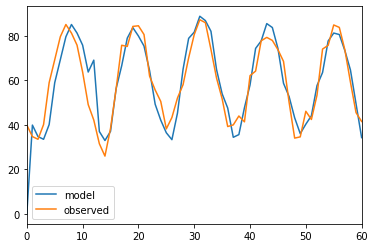

In [64]:
# Ok now I have my model selected. Lets go ahead and make some predictions:
sec_res.predict(start = 0, end = 60).plot(label = 'model', legend = True)
train.max_tmp.plot(label = 'observed', legend = True)


#The model looks pretty good on the training data

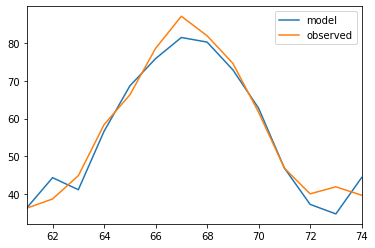

In [65]:
# Lets look at test data
sec_res.predict(start=61, end=74).plot(label = 'model', legend = True)
test.max_tmp.plot(label = 'observed', legend = True)

# Working on test data as well!

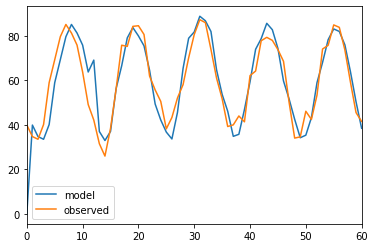

In [121]:
# Now, lets see what happens when we play around with the model so we can understand it with trial and error
cur = sarimax.SARIMAX(train.max_tmp, order=(0,1,1), seasonal_order = (0, 1, 1, 12))
cur_mod = cur.fit()

cur_mod.predict(start = 0, end = 60).plot(label = 'model', legend = True)
train.max_tmp.plot(label = 'observed', legend = True)

In [122]:
cur_mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                            max_tmp   No. Observations:                   61
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -150.292
Date:                            Fri, 24 Apr 2020   AIC                            306.584
Time:                                    12:55:23   BIC                            312.198
Sample:                                         0   HQIC                           308.705
                                             - 61                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7930      0.099     -8.050      0.000      -0.986      -0.600
ma.S.L12      -0.7579      0.272     -2.790      0.005      -1.290      -0.225
sigma2        24.6464      6.998      3.522      0.000      10.931      38.362
===================================================================================
Ljung-Box (Q):                       27.84   Jarque-Bera (JB):                 1.82
Prob(Q):                              0.93   Prob(JB):                         0.40
Heteroskedasticity (H):               1.06   Skew:                             0.28
Prob(H) (two-sided):                  0.91   Kurtosis:                         2.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [130]:
prac = sec_res.predict(start=61, end=74)
comm = cur_mod.predict(start=61, end=74)
truth = test.max_tmp

print('MSE for my model is {}'.format(np.around(mean_squared_error(truth, prac), 2)))
print('MSE for common model is {}'.format(np.around(mean_squared_error(truth, comm), 2)))

MSE for my model is 12.99
MSE for common model is 8.06
